<a href="https://colab.research.google.com/github/BNarayanaReddy/CS7015/blob/main/Chapter11_CNNs_LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Fri May 16 11:23:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
dataset = torchvision.datasets.FashionMNIST(root="content", download=True, transform = transform)

In [6]:
train_samples = int(0.8*len(dataset))
test_samples = len(dataset) - train_samples
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

In [7]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True )
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False )

In [8]:
num_classes = len(dataset.classes)
num_classes

10

In [9]:
# Simple Convolutional network (2d) on the grey images => channels =1
# Model
class ConvNet(nn.Module):
  def __init__(self, input_channels, output_dim):
    super().__init__()
    self.input_channels = input_channels
    self.classes = output_dim
    self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels = self.input_channels, out_channels = 32, kernel_size = 3), # 28 - 3 + (1)-> 25 + 1 => 26 dim f1 map
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3), # (26 - 3) + 1=> 24 output dim = 2, 24, 24 => 1152
            nn.ReLU()
    )
    self.fc = nn.Sequential(
            nn.Linear(in_features = 1152, out_features= 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = self.classes),
    )
    self.softmax = nn.Softmax(dim = 1)
  def forward(self, images):
    output = self.conv_layer(images)
    # print(output.shape)
    output = torch.flatten(output, start_dim = 1)
    output = self.fc(output)
    output = self.softmax(output)
    return output


In [10]:
conv_net = ConvNet(input_channels = 1, output_dim = num_classes)

In [11]:
c_e = nn.CrossEntropyLoss()

In [12]:
def fit_convnet(epochs = 10, lr = 1e-3, device = 'cpu'):
  optimizer = torch.optim.Adam(conv_net.parameters(), lr = lr)

  for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      conv_net.to(device)
      output = conv_net(images)
      loss = c_e(output, labels)
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        epoch_loss += loss.item()
    print("Epoch:", epoch)
    print("Loss:", epoch_loss/(len(train_loader)))
  return loss

In [13]:
fit_convnet(device='cuda')

Epoch: 0
Loss: 1.7708898642857869
Epoch: 1
Loss: 1.679641993522644
Epoch: 2
Loss: 1.6301131189664204
Epoch: 3
Loss: 1.6068603351910908
Epoch: 4
Loss: 1.5969701708157857
Epoch: 5
Loss: 1.587410096804301
Epoch: 6
Loss: 1.582434067249298
Epoch: 7
Loss: 1.5768487928708395
Epoch: 8
Loss: 1.5712508775393168
Epoch: 9
Loss: 1.5656699515978496


tensor(1.5840, device='cuda:0', grad_fn=<NllLossBackward0>)

In [14]:
for batch in test_loader:
  print(batch[1].shape)
  print(batch[1][0])
  break

torch.Size([64])
tensor(3)


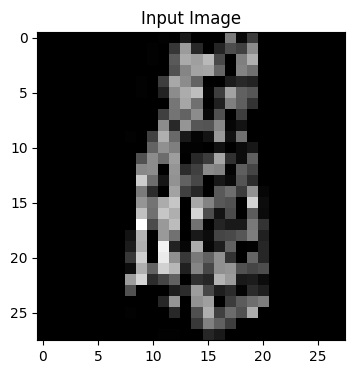

Class: 0 - Ground Truth : 3


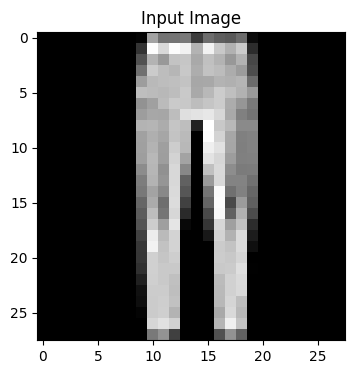

Class: 1 - Ground Truth : 1


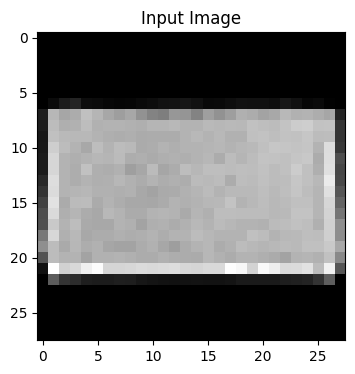

Class: 8 - Ground Truth : 8


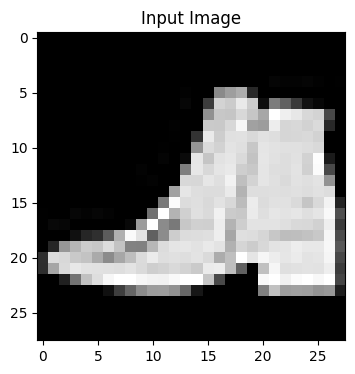

Class: 9 - Ground Truth : 9


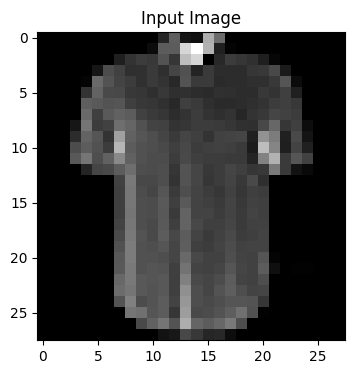

Class: 6 - Ground Truth : 6


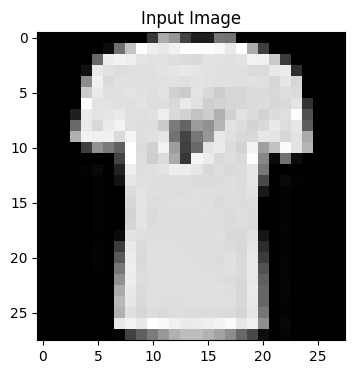

Class: 0 - Ground Truth : 0


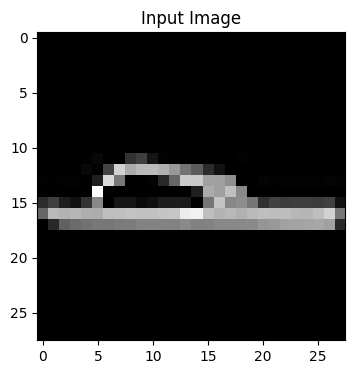

Class: 5 - Ground Truth : 5


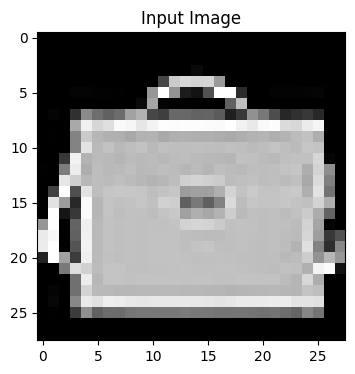

Class: 8 - Ground Truth : 8


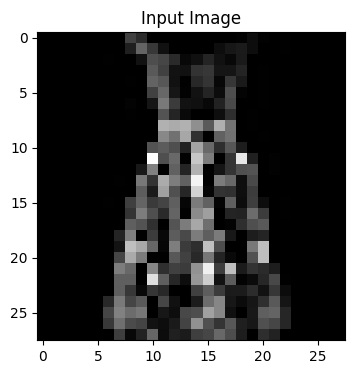

Class: 3 - Ground Truth : 3


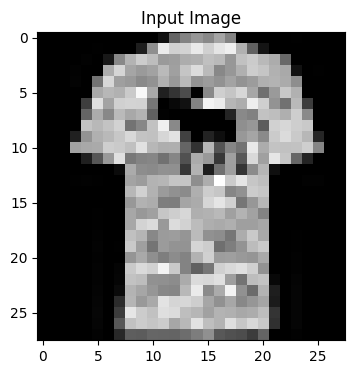

Class: 0 - Ground Truth : 0
Random_test Samples Accuracy 90.0


In [15]:
# prediction
i = 0
predictions = []
gnd_labels = []
for batch in test_loader:
  plt.figure(figsize=(12, 4))
  conv_net.eval()
  x = batch[0][0]
  label = batch[1][0]
  plt.subplot(1, 2, 1)
  plt.imshow(x.squeeze(), cmap='grey')
  plt.title("Input Image")
  plt.show()
  # Fwd Prop
  conv_net.to('cpu')
  x = x.unsqueeze(dim = 0)
  x_hat = conv_net(x)
  # x_hat = x_hat.view(-1, 28, 28)
  # detach from comp. graph
  x_hat = x_hat.detach()
  predictions.append(torch.argmax(x_hat))
  gnd_labels.append(label)
  print(f"Class: {torch.argmax(x_hat)} - Ground Truth : {label}" )
  i += 1
  if i == 10:
    break
print("Random_test Samples Accuracy",accuracy_score(predictions, gnd_labels)*100)

#### LeNet - 5

In [16]:
# Convolutional network (2d) on the grey images => channels =1
# LeNet - 5 Model CC Created by yann le cunn
class LeNet5(nn.Module):
  def __init__(self, input_channels, output_dim):
    super().__init__()
    self.input_channels = input_channels
    self.classes = output_dim
    self.le_net_conv = nn.Sequential(
            nn.Conv2d(in_channels = self.input_channels, out_channels = 6, kernel_size = 5),  #28 - 5 + 1 => 24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 24 -> 12

            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),  # 12 - 4 => 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 8 -> 4
            # Output -> 16, 4, 4 => 256


    )

    self.fc = nn.Sequential(
            nn.Linear(in_features = 256, out_features= 120),
            nn.ReLU(),
            nn.Linear(in_features = 120, out_features = 84),
            nn.ReLU(),
            nn.Linear(in_features = 84, out_features = self.classes),
    )
    self.softmax = nn.Softmax(dim = 1)
  def forward(self, images):
    output = self.le_net_conv(images)
    output = torch.flatten(output, start_dim = 1)
    output = self.fc(output)
    output = self.softmax(output)
    return output


In [17]:
le_net = LeNet5(input_channels = 1, output_dim = num_classes)

In [18]:
def fit_le_net(epochs = 10, lr = 1e-2, device = 'cpu'):
  optimizer = torch.optim.Adam(conv_net.parameters(), lr = lr)
  for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in train_loader:

      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      le_net.to(device)
      output = le_net(images)
      loss = c_e(output, labels)
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        epoch_loss += loss.item()
      # print(loss.item())
    print("Epoch:", epoch)
    print("Loss:", epoch_loss/(len(train_loader)))
  return loss

In [19]:
# Complex model but the FC layers at the output layers has less hidden units, => convergence require more time
fit_le_net(device='cuda')

Epoch: 0
Loss: 2.3023095763524375
Epoch: 1
Loss: 2.3023095814387005
Epoch: 2
Loss: 2.3023095865249634
Epoch: 3
Loss: 2.302309569676717
Epoch: 4
Loss: 2.3023095604578656
Epoch: 5
Loss: 2.3023095750808715
Epoch: 6
Loss: 2.302309582710266
Epoch: 7
Loss: 2.302309573809306
Epoch: 8
Loss: 2.3023095865249634
Epoch: 9
Loss: 2.302309583981832


tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>)

In [21]:
!pip install torchviz -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00


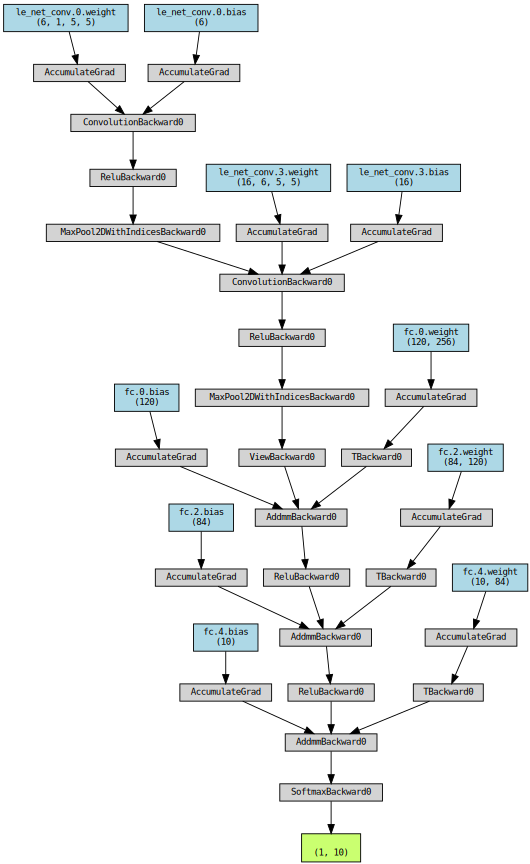

In [32]:
from torchviz import make_dot
make_dot(le_net(torch.randn(1, 1, 28, 28, device='cuda')), params=dict(le_net.named_parameters()))